In [136]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
from pint import UnitRegistry
unit = UNITS
import numpy as np
from math import * 



# By Solomon Greenberg

In [137]:

# Set up constants
m_earth = 5.972e24 * unit.kg
m_sun = 1.989e30 * unit.kg
G_const = 6.67408e-11 * unit.newton * unit.kg**-2 * unit.meter**2

earth_start_dist = 1 * unit.au

<Quantity(1, 'astronomical_unit')>

In [150]:
# Set up earth initial state
earth_state = State(
    x=earth_start_dist.to(unit.m),
    y=(0.0*unit.au).to(unit.m),
    dx=0*unit.m/unit.s,
    dy=30000*unit.m/unit.s,
)

x       149597870691.0 meter
y                  0.0 meter
dx        0.0 meter / second
dy    30000.0 meter / second
dtype: object

In [151]:
# Univ. gravitational attraction model
def grav_attraction(earth_state):
    x, y = earth_state.x, earth_state.y
    x = x.to(unit.m)
    y = y.to(unit.m)
    dist = np.sqrt(x**2 + y**2)
    force = (G_const * m_earth * m_sun / (dist**2)).to(unit.newton)
    direction = -np.asarray([x.m, y.m]) / np.linalg.norm(np.asarray([x.m, y.m]))
    return force, direction

grav_attraction(earth_state) # test

(<Quantity(3.542380155142107e+22, 'newton')>, array([-1., -0.]))

In [152]:
# Slope function + bonus hackery since ModSimPy is a really broken library
def calc_slopes(earth_state, _, __):
    print(earth_state)
    try : 
        x = earth_state.x.to(unit.m).m
        y = earth_state.y.to(unit.m).m
        dx = earth_state.dx.to(unit.m/unit.s).m
        dy = earth_state.dy.to(unit.m/unit.s).m
    except:
        x = earth_state[0]
        y = earth_state[1]
        dx = earth_state[2]
        dy = earth_state[3]
    finally:    
        earth_state = State(x=x*unit.m, y=y*unit.m, dx=dx*unit.m/unit.s, dy=dy*unit.m/unit.s)
        
    force, direction = grav_attraction(earth_state)
    earth_pos = np.asarray([i.to(unit.m).m for i in [earth_state.x, earth_state.y]])
    earth_vel = np.asarray([i.to(unit.m/unit.s).m for i in [earth_state.dx, earth_state.dy]])
    earth_acc = force / m_earth
    earth_acc_dx = earth_acc *direction[0]#* np.cos(atan2(earth_state.y.to(unit.m).m, earth_state.x.to(unit.m).m))
    earth_acc_dy = earth_acc *direction[1]#* np.sin(atan2(earth_state.y.to(unit.m).m, earth_state.x.to(unit.m).m))
    earth_dx = earth_state.dx
    earth_dy = earth_state.dy
    return earth_dx, earth_dy, earth_acc_dx, earth_acc_dy

In [153]:
calc_slopes(earth_state, None, None) # Sanity check

x       149597870691.0 meter
y                  0.0 meter
dx        0.0 meter / second
dy    30000.0 meter / second
dtype: object


(<Quantity(0.0, 'meter / second')>,
 <Quantity(30000.0, 'meter / second')>,
 <Quantity(-0.0059316479489988395, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [161]:
sys = System(init=earth_state, t_end=1000*unit.day) # System object... necessary I suppose

init     x       149597870691.0 meter
y                ...
t_end                                             1000 day
dtype: object

In [176]:
results, details = run_ode_solver(sys, calc_slopes, max_step=1*unit.day, method='RK23')# I literally have no idea how to make this stop printing all the results

[1.49597871e+11 0.00000000e+00 0.00000000e+00 3.00000000e+04]
[ 1.49597871e+11  1.41421354e-05 -2.79620561e-12  3.00000000e+04]
[ 1.49597871e+11  7.07106769e-04 -1.39810281e-10  3.00000000e+04]
[ 1.49597871e+11  1.06066015e-03 -2.09715421e-10  3.00000000e+04]
[ 1.49597871e+11  1.41421354e-03 -2.79620561e-10  3.00000000e+04]
[ 1.49597871e+11  8.48528123e-03 -1.67772337e-09  3.00000000e+04]
[ 1.49597871e+11  1.20208151e-02 -2.37677477e-09  3.00000000e+04]
[ 1.49597871e+11  1.55563489e-02 -3.07582617e-09  3.00000000e+04]
[ 1.49597871e+11  8.62670259e-02 -1.70568542e-08  3.00000000e+04]
[ 1.49597871e+11  1.21622364e-01 -2.40473683e-08  3.00000000e+04]
[ 1.49597871e+11  1.56977703e-01 -3.10378823e-08  3.00000000e+04]
[ 1.49597871e+11  8.64084472e-01 -1.70848163e-07  3.00000000e+04]
[ 1.49597871e+11  1.21763786e+00 -2.40753303e-07  3.00000000e+04]
[ 1.49597871e+11  1.57119124e+00 -3.10658444e-07  3.00000000e+04]
[ 1.49597871e+11  8.64225894e+00 -1.70876125e-06  3.00000000e+04]
[ 1.49597871e+

[ 1.03199919e+11  1.09220550e+11 -2.15002940e+04  2.07363554e+04] dimensionless
[ 1.02727907e+11  1.09660543e+11 -2.15858865e+04  2.06425929e+04] dimensionless
[ 1.02263594e+11  1.10108365e+11 -2.16731229e+04  2.05502673e+04] dimensionless
[ 1.01327315e+11  1.10996136e+11 -2.18459438e+04  2.03641891e+04] dimensionless
[ 1.00847977e+11  1.11427964e+11 -2.19298840e+04  2.02690056e+04] dimensionless
[ 1.00376199e+11  1.11867748e+11 -2.20154919e+04  2.01752290e+04] dimensionless
[ 9.94251299e+10  1.12739318e+11 -2.21850321e+04  1.99862790e+04] dimensionless
[ 9.89386090e+10  1.13162859e+11 -2.22672967e+04  1.98897046e+04] dimensionless
[ 9.84595085e+10  1.13594482e+11 -2.23512521e+04  1.97945068e+04] dimensionless
[ 9.74939345e+10  1.14449605e+11 -2.25174644e+04  1.96027447e+04] dimensionless
[ 9.70003769e+10  1.14864740e+11 -2.25980305e+04  1.95048098e+04] dimensionless
[ 9.65140972e+10  1.15288080e+11 -2.26803100e+04  1.94082209e+04] dimensionless
[ 9.55343078e+10  1.16126515e+11 -2.2843

[-3.98060703e+10  1.46997205e+11 -2.85497015e+04 -7.30978876e+03] dimensionless
[-4.04233598e+10  1.46841915e+11 -2.85178788e+04 -7.42928340e+03] dimensionless
[-4.16553321e+10  1.46520970e+11 -2.84522634e+04 -7.66763802e+03] dimensionless
[-4.22670664e+10  1.46345052e+11 -2.84165017e+04 -7.78587327e+03] dimensionless
[-4.28815219e+10  1.46179467e+11 -2.83827016e+04 -7.90476447e+03] dimensionless
[-4.41076546e+10  1.45837981e+11 -2.83131441e+04 -8.14188026e+03] dimensionless
[-4.47162136e+10  1.45651873e+11 -2.82754301e+04 -8.25944815e+03] dimensionless
[-4.53276648e+10  1.45476047e+11 -2.82396647e+04 -8.37770379e+03] dimensionless
[-4.65476184e+10  1.45114130e+11 -2.81661898e+04 -8.61351674e+03] dimensionless
[-4.71528339e+10  1.44917891e+11 -2.81265365e+04 -8.73038568e+03] dimensionless
[-4.77611117e+10  1.44731879e+11 -2.80888185e+04 -8.84797389e+03] dimensionless
[-4.89745486e+10  1.44349646e+11 -2.80114518e+04 -9.08242055e+03] dimensionless
[-4.95762537e+10  1.44143338e+11 -2.7969

[-1.28667410e+11  8.38123231e+10 -1.61438413e+04 -2.43624511e+04] dimensionless
[-1.29018273e+11  8.32875977e+10 -1.60422057e+04 -2.44292520e+04] dimensionless
[-1.29711297e+11  8.22322540e+10 -1.58379025e+04 -2.45611397e+04] dimensionless
[-1.30044570e+11  8.16960358e+10 -1.57341953e+04 -2.46245194e+04] dimensionless
[-1.30386609e+11  8.11656137e+10 -1.56315016e+04 -2.46896235e+04] dimensionless
[-1.31061889e+11  8.00990219e+10 -1.54251101e+04 -2.48181021e+04] dimensionless
[-1.31386156e+11  7.95574006e+10 -1.53204010e+04 -2.48797540e+04] dimensionless
[-1.31719280e+11  7.90214290e+10 -1.52166770e+04 -2.49431453e+04] dimensionless
[-1.32376640e+11  7.79438851e+10 -1.50082533e+04 -2.50681835e+04] dimensionless
[-1.32691815e+11  7.73970107e+10 -1.49025704e+04 -2.51280925e+04] dimensionless
[-1.33015937e+11  7.68556382e+10 -1.47978442e+04 -2.51897557e+04] dimensionless
[-1.33655203e+11  7.57674407e+10 -1.45874446e+04 -2.53113230e+04] dimensionless
[-1.33961203e+11  7.52154644e+10 -1.4480

[-1.52307293e+11 -2.20411484e+10  4.23623233e+03 -2.88517812e+04] dimensionless
[-1.52218390e+11 -2.26646402e+10  4.35613542e+03 -2.88349299e+04] dimensionless
[-1.52030205e+11 -2.39103091e+10  4.59562745e+03 -2.87992706e+04] dimensionless
[-1.51920593e+11 -2.45308329e+10  4.71491203e+03 -2.87785039e+04] dimensionless
[-1.51821346e+11 -2.51527844e+10  4.83453151e+03 -2.87596906e+04] dimensionless
[-1.51612494e+11 -2.63952030e+10  5.07342519e+03 -2.87201122e+04] dimensionless
[-1.51492588e+11 -2.70138476e+10  5.19236386e+03 -2.86973933e+04] dimensionless
[-1.51383021e+11 -2.76340895e+10  5.31166851e+03 -2.86766224e+04] dimensionless
[-1.51153557e+11 -2.88729196e+10  5.54990147e+03 -2.86331344e+04] dimensionless
[-1.51023388e+11 -2.94895167e+10  5.66846315e+03 -2.86084685e+04] dimensionless
[-1.50903531e+11 -3.01078802e+10  5.78742181e+03 -2.85857450e+04] dimensionless
[-1.50653514e+11 -3.13427843e+10  6.02493181e+03 -2.85383576e+04] dimensionless
[-1.50513115e+11 -3.19571657e+10  6.1430

[-8.69525491e+10 -1.25844857e+11  2.43342205e+04 -1.63924779e+04] dimensionless
[-8.64285025e+10 -1.26201063e+11  2.44043012e+04 -1.62919435e+04] dimensionless
[-8.53742367e+10 -1.26904875e+11  2.45427974e+04 -1.60897143e+04] dimensionless
[-8.48381292e+10 -1.27243676e+11  2.46095508e+04 -1.59868495e+04] dimensionless
[-8.43081006e+10 -1.27591147e+11  2.46779826e+04 -1.58851275e+04] dimensionless
[-8.32420118e+10 -1.28277384e+11  2.48131611e+04 -1.56805496e+04] dimensionless
[-8.27002078e+10 -1.28607247e+11  2.48782253e+04 -1.55765501e+04] dimensionless
[-8.21643404e+10 -1.28945881e+11  2.49449878e+04 -1.54736667e+04] dimensionless
[-8.10867170e+10 -1.29614343e+11  2.50768079e+04 -1.52667927e+04] dimensionless
[-8.05393633e+10 -1.29935169e+11  2.51401633e+04 -1.51616853e+04] dimensionless
[-7.99978023e+10 -1.30264868e+11  2.52052363e+04 -1.50576670e+04] dimensionless
[-7.89089361e+10 -1.30915359e+11  2.53336583e+04 -1.48485504e+04] dimensionless
[-7.83561813e+10 -1.31227054e+11  2.5395

[ 8.75484731e+10 -1.22399552e+11  2.40589149e+04  1.76298115e+04] dimensionless
[ 8.80618586e+10 -1.22009797e+11  2.39834685e+04  1.77315658e+04] dimensionless
[ 8.85814283e+10 -1.21629064e+11  2.39097904e+04  1.78345722e+04] dimensionless
[ 8.96143312e+10 -1.20858611e+11  2.37606726e+04  1.80393223e+04] dimensionless
[ 9.01211198e+10 -1.20460116e+11  2.36834641e+04  1.81398078e+04] dimensionless
[ 9.06342486e+10 -1.20070539e+11  2.36080032e+04  1.82415771e+04] dimensionless
[ 9.16541144e+10 -1.19282503e+11  2.34553408e+04  1.84438215e+04] dimensionless
[ 9.21541547e+10 -1.18875380e+11  2.33763912e+04  1.85430067e+04] dimensionless
[ 9.26606895e+10 -1.18477067e+11  2.32991680e+04  1.86435071e+04] dimensionless
[ 9.36672136e+10 -1.17671668e+11  2.31430024e+04  1.88431823e+04] dimensionless
[ 9.41603561e+10 -1.17256029e+11  2.30623334e+04  1.89410361e+04] dimensionless
[ 9.46601456e+10 -1.16849093e+11  2.29833690e+04  1.90402360e+04] dimensionless
[ 9.56530272e+10 -1.16026554e+11  2.2823

[ 1.49333939e+11  8.94736846e+09 -1.76904162e+03  2.99470387e+04] dimensionless
[ 1.49257517e+11  1.02410805e+10 -2.02481687e+03  2.99317139e+04] dimensionless
[ 1.49202731e+11  1.08869435e+10 -2.15245662e+03  2.99207313e+04] dimensionless
[ 1.49159005e+11  1.15333410e+10 -2.28029286e+03  2.99119597e+04] dimensionless
[ 1.49060496e+11  1.28255377e+10 -2.53575571e+03  2.98922067e+04] dimensionless
[ 1.48994688e+11  1.34703560e+10 -2.66318020e+03  2.98790152e+04] dimensionless
[ 1.48939927e+11  1.41159004e+10 -2.79084050e+03  2.98680307e+04] dimensionless
[ 1.48819363e+11  1.54061993e+10 -3.04591218e+03  2.98438561e+04] dimensionless
[ 1.48742552e+11  1.60497823e+10 -3.17308212e+03  2.98284600e+04] dimensionless
[ 1.48676774e+11  1.66942825e+10 -3.30052712e+03  2.98152662e+04] dimensionless
[ 1.48534192e+11  1.79823020e+10 -3.55512899e+03  2.97866781e+04] dimensionless
[ 1.48446402e+11  1.86244593e+10 -3.68200521e+03  2.97690826e+04] dimensionless
[ 1.48369628e+11  1.92677247e+10 -3.8091

[ 6.29135038e+10  1.37080741e+11 -2.68819047e+04  1.27588375e+04] dimensionless
[ 6.23340720e+10  1.37358771e+11 -2.69349788e+04  1.26444843e+04] dimensionless
[ 6.11704809e+10  1.37905013e+11 -2.70391334e+04  1.24149702e+04] dimensionless
[ 6.05819361e+10  1.38163261e+11 -2.70882271e+04  1.22989957e+04] dimensionless
[ 5.99980054e+10  1.38431378e+11 -2.71393223e+04  1.21838052e+04] dimensionless
[ 5.88255867e+10  1.38957718e+11 -2.72395072e+04  1.19526520e+04] dimensionless
[ 5.82328853e+10  1.39205910e+11 -2.72865981e+04  1.18359104e+04] dimensionless
[ 5.76446272e+10  1.39464042e+11 -2.73357020e+04  1.17199177e+04] dimensionless
[ 5.64637249e+10  1.39970343e+11 -2.74318931e+04  1.14871953e+04] dimensionless
[ 5.58670406e+10  1.40208412e+11 -2.74769702e+04  1.13697219e+04] dimensionless
[ 5.52746276e+10  1.40456493e+11 -2.75240711e+04  1.12529621e+04] dimensionless
[ 5.40855877e+10  1.40942621e+11 -2.76162455e+04  1.10187407e+04] dimensionless
[ 5.34850949e+10  1.41170507e+11 -2.7659

[-6.63414105e+10  1.37506428e+11 -2.66402591e+04 -1.24316186e+04] dimensionless
[-6.74922697e+10  1.36969382e+11 -2.65333527e+04 -1.26532044e+04] dimensionless
[-6.80607718e+10  1.36686500e+11 -2.64771872e+04 -1.27625582e+04] dimensionless
[-6.86337881e+10  1.36413246e+11 -2.64228173e+04 -1.28728971e+04] dimensionless
[-6.97752538e+10  1.35857137e+11 -2.63122878e+04 -1.30925803e+04] dimensionless
[-7.03388243e+10  1.35564847e+11 -2.62543370e+04 -1.32009398e+04] dimensionless
[-7.09070666e+10  1.35282104e+11 -2.61981640e+04 -1.33103128e+04] dimensionless
[-7.20388273e+10  1.34707099e+11 -2.60840461e+04 -1.35280359e+04] dimensionless
[-7.25973128e+10  1.34405487e+11 -2.60243280e+04 -1.36353727e+04] dimensionless
[-7.31606260e+10  1.34113340e+11 -2.59663694e+04 -1.37437513e+04] dimensionless
[-7.42823732e+10  1.33519610e+11 -2.58486989e+04 -1.39594573e+04] dimensionless
[-7.48356217e+10  1.33208768e+11 -2.57872320e+04 -1.40657436e+04] dimensionless
[-7.53938526e+10  1.32907303e+11 -2.5727

[-1.53847081e+11 -4.72932267e+09  9.08850342e+02 -2.91434843e+04] dimensionless
[-1.53807818e+11 -5.98832119e+09  1.15079504e+03 -2.91360468e+04] dimensionless
[-1.53772509e+11 -6.61733851e+09  1.27164229e+03 -2.91293595e+04] dimensionless
[-1.53747657e+11 -7.24656312e+09  1.39260055e+03 -2.91246498e+04] dimensionless
[-1.53687496e+11 -8.50474799e+09  1.63439557e+03 -2.91132533e+04] dimensionless
[-1.53641748e+11 -9.13310194e+09  1.75512080e+03 -2.91045887e+04] dimensionless
[-1.53606452e+11 -9.76183430e+09  1.87598846e+03 -2.90978999e+04] dimensionless
[-1.53525409e+11 -1.10188636e+10  2.11757089e+03 -2.90825471e+04] dimensionless
[-1.53469233e+11 -1.16463834e+10  2.23814268e+03 -2.90719072e+04] dimensionless
[-1.53423502e+11 -1.22744526e+10  2.35888830e+03 -2.90632408e+04] dimensionless
[-1.53321598e+11 -1.35299846e+10  2.60019525e+03 -2.90439353e+04] dimensionless
[-1.53255009e+11 -1.41564996e+10  2.72058220e+03 -2.90313228e+04] dimensionless
[-1.53198855e+11 -1.47837349e+10  2.8411

[-4.18823721e+10 -1.46459632e+11  2.84397520e+04 -7.71153442e+03] dimensionless
[-4.12650529e+10 -1.46615963e+11  2.84717548e+04 -7.59211479e+03] dimensionless
[-4.06508678e+10 -1.46782497e+11  2.85057364e+04 -7.47328087e+03] dimensionless
[-3.94194200e+10 -1.47105342e+11  2.85717168e+04 -7.23503807e+03] dimensionless
[-3.87994206e+10 -1.47251327e+11  2.86017320e+04 -7.11504445e+03] dimensionless
[-3.81823858e+10 -1.47407571e+11  2.86337374e+04 -6.99560413e+03] dimensionless
[-3.69454083e+10 -1.47709781e+11  2.86957542e+04 -6.75618102e+03] dimensionless
[-3.63229009e+10 -1.47845371e+11  2.87237707e+04 -6.63564600e+03] dimensionless
[-3.57031875e+10 -1.47991273e+11  2.87537881e+04 -6.51563164e+03] dimensionless
[-3.44610238e+10 -1.48272748e+11  2.88118185e+04 -6.27509317e+03] dimensionless
[-3.38361816e+10 -1.48397899e+11  2.88378257e+04 -6.15404960e+03] dimensionless
[-3.32139619e+10 -1.48533411e+11  2.88658441e+04 -6.03349381e+03] dimensionless
[-3.19669574e+10 -1.48794058e+11  2.8919

[ 7.48523562e+10 -1.30748203e+11  2.56690563e+04  1.51165862e+04] dimensionless
[ 7.54080848e+10 -1.30424095e+11  2.56067608e+04  1.52264853e+04] dimensionless
[ 7.65142968e+10 -1.29766310e+11  2.54802929e+04  1.54452213e+04] dimensionless
[ 7.70592077e+10 -1.29423244e+11  2.54142368e+04  1.55530012e+04] dimensionless
[ 7.76094737e+10 -1.29089688e+11  2.53500461e+04  1.56618656e+04] dimensionless
[ 7.87045957e+10 -1.28413096e+11  2.52198049e+04  1.58784988e+04] dimensionless
[ 7.92437171e+10 -1.28060762e+11  2.51518878e+04  1.59851773e+04] dimensionless
[ 7.97883574e+10 -1.27717849e+11  2.50858185e+04  1.60929734e+04] dimensionless
[ 8.08720648e+10 -1.27022633e+11  2.49518381e+04  1.63074369e+04] dimensionless
[ 8.14052366e+10 -1.26661127e+11  2.48820779e+04  1.64129809e+04] dimensionless
[ 8.19440899e+10 -1.26308951e+11  2.48141474e+04  1.65196754e+04] dimensionless
[ 8.30160611e+10 -1.25595301e+11  2.46764628e+04  1.67319029e+04] dimensionless
[ 8.35431247e+10 -1.25224724e+11  2.4604

[ 1.49188668e+11  1.11388461e+10 -2.20229995e+03  2.99178747e+04] dimensionless
[ 1.49093528e+11  1.24312983e+10 -2.45781522e+03  2.98987972e+04] dimensionless
[ 1.49029401e+11  1.30762882e+10 -2.58527493e+03  2.98859425e+04] dimensionless
[ 1.48976324e+11  1.37219749e+10 -2.71296445e+03  2.98752956e+04] dimensionless
[ 1.48859124e+11  1.50125877e+10 -2.96810056e+03  2.98517954e+04] dimensionless
[ 1.48783991e+11  1.56563712e+10 -3.09531171e+03  2.98367355e+04] dimensionless
[ 1.48719894e+11  1.63010429e+10 -3.22279194e+03  2.98238788e+04] dimensionless
[ 1.48580669e+11  1.75894345e+10 -3.47747023e+03  2.97959637e+04] dimensionless
[ 1.48494554e+11  1.82318214e+10 -3.60439363e+03  2.97787036e+04] dimensionless
[ 1.48419456e+11  1.88752874e+10 -3.73162527e+03  2.97636413e+04] dimensionless
[ 1.48258250e+11  2.01610767e+10 -3.98576726e+03  2.97313207e+04] dimensionless
[ 1.48161178e+11  2.08018769e+10 -4.11236383e+03  2.97118661e+04] dimensionless
[ 1.48075104e+11  2.14439470e+10 -4.2393

[ 5.32540775e+10  1.41265822e+11 -2.76773646e+04  1.08550097e+04] dimensionless
[ 5.20584153e+10  1.41734759e+11 -2.77661187e+04  1.06195739e+04] dimensionless
[ 5.14548330e+10  1.41953971e+11 -2.78074485e+04  1.05008420e+04] dimensionless
[ 5.08552018e+10  1.42183314e+11 -2.78508204e+04  1.03827579e+04] dimensionless
[ 4.96520464e+10  1.42631850e+11 -2.79355189e+04  1.01459538e+04] dimensionless
[ 4.90449802e+10  1.42840772e+11 -2.79748068e+04  1.00265911e+04] dimensionless
[ 4.84416906e+10  1.43059888e+11 -2.80161457e+04  9.90784046e+03] dimensionless
[ 4.72313931e+10  1.43487907e+11 -2.80967695e+04  9.66973906e+03] dimensionless
[ 4.66210199e+10  1.43686487e+11 -2.81340068e+04  9.54978120e+03] dimensionless
[ 4.60142477e+10  1.43895319e+11 -2.81733034e+04  9.43039964e+03] dimensionless
[ 4.47971610e+10  1.44302712e+11 -2.82498345e+04  9.19107217e+03] dimensionless
[ 4.41836585e+10  1.44490900e+11 -2.82850131e+04  9.07055490e+03] dimensionless
[ 4.35735806e+10  1.44689394e+11 -2.8322

[-8.05552773e+10  1.29936667e+11 -2.51403351e+04 -1.51647337e+04] dimensionless
[-8.10927969e+10  1.29600051e+11 -2.50739939e+04 -1.52678787e+04] dimensionless
[-8.16357302e+10  1.29272558e+11 -2.50093376e+04 -1.53721704e+04] dimensionless
[-8.27161336e+10  1.28608480e+11 -2.48783468e+04 -1.55795982e+04] dimensionless
[-8.32478471e+10  1.28263000e+11 -2.48103317e+04 -1.56815884e+04] dimensionless
[-8.37851227e+10  1.27926547e+11 -2.47439810e+04 -1.57847517e+04] dimensionless
[-8.48540626e+10  1.27244645e+11 -2.46096221e+04 -1.59898965e+04] dimensionless
[-8.53798262e+10  1.26890401e+11 -2.45399533e+04 -1.60907057e+04] dimensionless
[-8.59112984e+10  1.26545087e+11 -2.44719284e+04 -1.61927141e+04] dimensionless
[-8.69684857e+10  1.25845562e+11 -2.43342417e+04 -1.63955230e+04] dimensionless
[-8.74881573e+10  1.25482658e+11 -2.42629401e+04 -1.64951253e+04] dimensionless
[-8.80136825e+10  1.25128583e+11 -2.41932613e+04 -1.65959525e+04] dimensionless
[-8.90588314e+10  1.24411638e+11 -2.4052

[-1.45229254e+11 -5.06045160e+10  9.73239737e+03 -2.75096594e+04] dimensionless
[-1.45021533e+11 -5.11995082e+10  9.84704604e+03 -2.74702364e+04] dimensionless
[-1.44596140e+11 -5.23862224e+10  1.00756707e+04 -2.73895210e+04] dimensionless
[-1.44368629e+11 -5.29743492e+10  1.01889831e+04 -2.73463548e+04] dimensionless
[-1.44151033e+11 -5.35658550e+10  1.03029881e+04 -2.73050512e+04] dimensionless
[-1.43705944e+11 -5.47454332e+10  1.05302954e+04 -2.72205848e+04] dimensionless
[-1.43468670e+11 -5.53297489e+10  1.06429041e+04 -2.71755586e+04] dimensionless
[-1.43241256e+11 -5.59176062e+10  1.07562352e+04 -2.71323842e+04] dimensionless
[-1.42776587e+11 -5.70897252e+10  1.09821650e+04 -2.70441871e+04] dimensionless
[-1.42529612e+11 -5.76700696e+10  1.10940401e+04 -2.69973117e+04] dimensionless
[-1.42292439e+11 -5.82541174e+10  1.12066674e+04 -2.69522768e+04] dimensionless
[-1.41808311e+11 -5.94184557e+10  1.14311599e+04 -2.68603702e+04] dimensionless
[-1.41551700e+11 -5.99946694e+10  1.1542

In [173]:
plot(results.x)
decorate(xlabel='Time (s)',
         ylabel='Earth x position (m)')


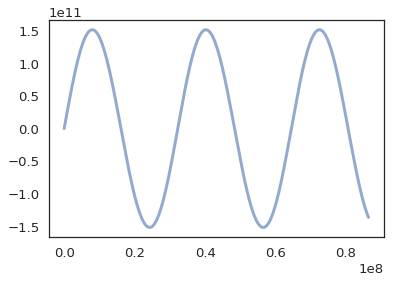

In [164]:
plot(results.y)
decorate(xlabel='Time (s)',
         ylabel='Earth y position (m)')


In [165]:
plot(results.dx)
decorate(xlabel='Time (s)',
         ylabel='Earth x velocity (m/s)')


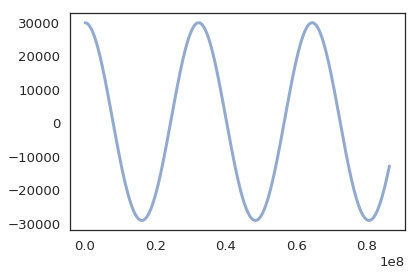

In [166]:
plot(results.dy)
decorate(xlabel='Time (s)',
         ylabel='Earth y velocity (m/s)')


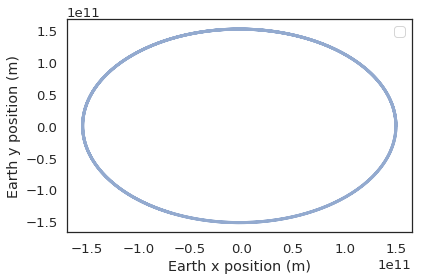

In [174]:
plot(results.x, results.y)
decorate(xlabel='Earth x position (m)',
         ylabel='Earth y position (m)')
